# Unit Conversion

In this notebook we are gonna have a look at the conversion of units. 
The Sentinel-1 data that is mostly used in this exercise is SAR data, which is measured in decibels (dB). In order to make meaningful calculations with the data, we need to convert the data to linear scale. Lets start with importing some libraries.

In [2]:
# Imports
import numpy as np
import pystac_client
import odc.stac
import matplotlib.pyplot as plt
from odc.geo.geobox import GeoBox
from dask.diagnostics import ProgressBar
from rasterio.crs import CRS
import seaborn as sns

## Backscattering Coefficients
Lets have a quick look at the different backscattering coefficients that are used in SAR data processing:
- **radar brightness** or **beta nought** $\beta^0$: Is the original backscatter value related to the measurement geometry (range and azimuth). Thus, it is a quantity being independent from terrain variations (and hence also incidence angles).
- **sigma nought** $\sigma^0$: Is the backscatter value related to the illuminated ground-area. It takes the influence of terrain variations causing a variation in illumination into account, by scaling $\beta^0$ with $sin(\theta_i)$, where $\theta_i$ is the local incidence angle.
- **gamma nought** $\gamma^0$: Is the backscatter value related to the area perpendicular to the looking direction. It can be computed by normalising/scaling $\beta^0$ with $1/tan(\theta_i)$

## Scale
The decibel (dB) is a logarithmic unit used to express the ratio of two values of a physical quantity, often power or intensity. In the case of SAR data, the backscatter coefficient is often expressed in dB. The reason for that will be explained in the following example.

## Mathematical operation
In order to convert the data from dB to linear scale, we need to convert the data using the following formula.
Let $x$ be the original value (dB) and $y$ the converted value ($m^2m^{-2}$). The conversion of units can be expressed as:
$$
D =  10  \cdot \log_{10} (I) = 10 \cdot \log_{10} (e) \cdot \ln (I)\longrightarrow [dB]
$$
Similarly, the conversion back to the original unit can be expressed as:
$$
I = e^{\frac{D}{10\cdot \log_{10}(e)}} = 10^{\frac{D}{10}} \longrightarrow [m^2m^{-2}]	
$$
You can find these formulas in the script for `Microwave Remote Sensing` on ``page 136 (equation 6.40)``.

Now lets implement the conversion in Python.

In [3]:
# Conversion functions
def lin2db(val:float|int) -> float:
    '''
    Converts value from linear to dB units.

    Parameters
    ----------
    x : number
        Value in linear units.

    Returns
    -------
    float
        Value in dB.
    '''
    return 10 * np.log10(val)

def db2lin(val:float|int) -> float:
    '''
    Converts value from dB to linear units.

    Parameters
    ----------
    x : number
        Value in dB.

    Returns
    -------
    float
        Value in linear units.
    '''
    return 10 ** (val / 10)

The reason why we convert the data to linear scale is that when values in dB are added or subtracted, the actual values are multiplied or divided. This is not the case when the values are in linear scale. Lets have a look at an example, where we add two values in once without the conversion to linear scale and once with the conversion to linear scale.

In [4]:
# Logarithmic addition
# Values in linear and decibel units
val1_db, val2_db = 10, 12

# Logarithmic addition
sum_db = val1_db + val2_db
print(f'Logarithmic Addition:')
print(f'Logarithmic values: \t{val1_db:<5}, {val2_db:<5} [dB]')
print(f'Logarithmic sum: \t{val1_db} + {val2_db} = {sum_db:<5}')

# Linear addition
val1_lin, val2_lin = db2lin(val1_db), db2lin(val2_db)
sum_lin = val1_lin + val2_lin
print(f'\nLinear Addition:')
print(f'Linear values: \t\t{val1_lin:<5}, {val2_lin:<5.2f} [lin] (converted from dB)')
print(f'Linear sum: \t\t{val1_lin} + {val2_lin:.2f} = {sum_lin:.2f} [lin]')
print(f'\t\t\t= {lin2db(sum_lin):.2f} [dB]')

print(f'\nValues compared in dB: \t{sum_db} [dB] != {lin2db(sum_lin):.2f} [dB] (difference = {sum_db - lin2db(sum_lin):.2f} [dB])')
print(f'Values compared in lin: {db2lin(sum_db):.2f} [lin] != {sum_lin:.2f} [lin] (factor = {db2lin(sum_db) / sum_lin:.2f})')

Logarithmic Addition:
Logarithmic values: 	10   , 12    [dB]
Logarithmic sum: 	10 + 12 = 22   

Linear Addition:
Linear values: 		10.0 , 15.85 [lin] (converted from dB)
Linear sum: 		10.0 + 15.85 = 25.85 [lin]
			= 14.12 [dB]

Values compared in dB: 	22 [dB] != 14.12 [dB] (difference = 7.88 [dB])
Values compared in lin: 158.49 [lin] != 25.85 [lin] (factor = 6.13)


As you can see the values in dB and in linear scale differ quite a bit. In the example above the values differ by a factor of around 6 when looked at in linear scale. This is why it is important to convert the data to linear scale before doing any calculations.
Lets load some sample data and see what the difference is between the two scales and why we use dB in the first place.

## Example Usage

### Load some sample data
In order to demonstrate why this conversion is important, we will have a look at some SAR data.

In [5]:
# Search for some data

epsg = CRS.from_epsg(4326) # WGS 84 (only integer would also work)
dx = 0.0002 # degrees

# Set Spatial extent
latmin, latmax = 48, 48.5
lonmin, lonmax = 16, 17
bounds = (lonmin, latmin, lonmax, latmax)
minx, miny, maxx, maxy = bounds
geom = {
    'type': 'Polygon',
    'coordinates': [[
       [minx, miny],
       [minx, maxy],
       [maxx, maxy],
       [maxx, miny],
       [minx, miny]
    ]]
}

# Set Temporal extent
time_range = "2022-08-01/2022-08-05" # closed range

# Search for Sentinel-2 data
items = pystac_client.Client.open("https://stac.eodc.eu/api/v1").search(
    # intersects=geom,
    bbox=bounds,
    collections=["SENTINEL1_SIG0_20M"],
    datetime=time_range,
    limit=100,
).item_collection()

print(len(items), 'scenes found')

12 scenes found


In [6]:
# Load the data into a Dask array

# define a geobox for my region
geobox = GeoBox.from_bbox(bounds, crs=epsg, resolution=dx)

# lazily combine items
sig0_dc = odc.stac.stac_load(
    items,
    #bbox=bounds,
    bands=["VV", "VH"],
    chunks={'time': 5, 'x': 600, 'y': 600},
    epsg=epsg,
    geobox=geobox,
    resampling="bilinear",
)

In [7]:
# Define the nodata value and scale factor
nodata = -9999  # Sentinel-1 nodata value as defined by EODC
scale = 0.1     # Sentinel-1 scale factor as defined by EODC

# Preprocess the data
temp_mean = (sig0_dc.where(sig0_dc != nodata)*scale).VV.median(dim='time')

/home/jlinke/miniconda3/envs/02_unit-conversions/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


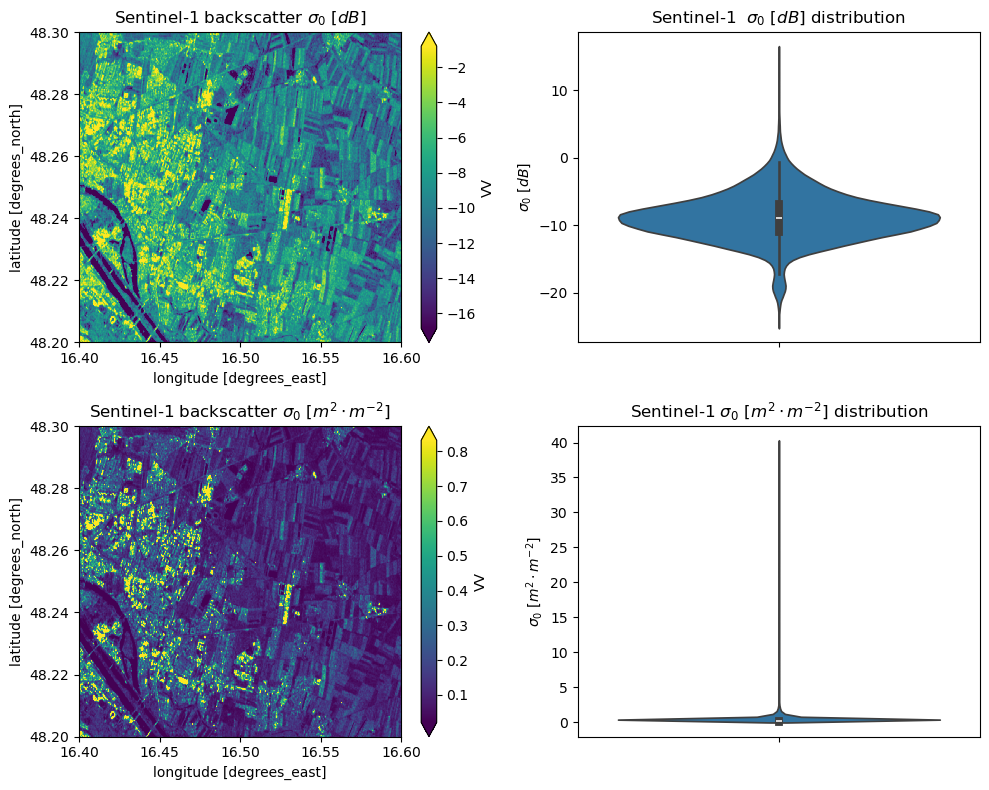

In [8]:
aoi = temp_mean.sel(latitude=slice(48.3, 48.2), longitude=slice(16.4, 16.6))
dB_data = aoi.values.flatten()
lin_data = db2lin(dB_data)

fig, ax = plt.subplots(2,2, figsize=(10,8))
#upper left
aoi.plot.imshow(robust=True, ax=ax[0,0])
ax[0,0].set_title('Sentinel-1 backscatter $\sigma_0$ [$dB$]')

#upper right
sns.violinplot(data=dB_data, ax=ax[0,1])
ax[0,1].set_ylabel('$\sigma_0$ [$dB$]')
ax[0,1].set_title('Sentinel-1  $\sigma_0$ [$dB$] distribution')

#lower left
db2lin(aoi).plot.imshow(robust=True, ax=ax[1,0])
ax[1,0].set_title('Sentinel-1 backscatter $\sigma_0$ [$m^2 \cdot m^{-2}$]')


#lower right
sns.violinplot(data=lin_data, ax=ax[1,1])
ax[1,1].set_ylabel('$\sigma_0$ [$m^2 \cdot m^{-2}$]')
ax[1,1].set_title('Sentinel-1 $\sigma_0$ [$m^2 \cdot m^{-2}$] distribution')
plt.tight_layout()

In the plot above you can see the difference between the two scales. The values in dB are more evenly distributed and are therefore easier to plot. The values in linear scale are more spread out and are therefore harder to interpret.
This is why we use the dB scale for plotting and the linear scale for calculations.

Now that we have some data, we will try to calculate the average $\sigma_0$ value across the scene. We will do this by converting the data to linear scale, calculating the average and converting it back to dB. 

In [9]:
# Lets take a data array with db values
db_array = temp_mean.compute()

# Compute the linear values
lin_array = db2lin(db_array)

In [10]:
# Compute the average backscatter value in linear units across the whole scene
lin_mean = lin_array.mean()
print(f"Average backscatter value in linear units: {lin_mean.values:.3f}")
db_from_lin_mean = lin2db(lin_mean)
print(f"That value in dB: {db_from_lin_mean.values:.3f}\n")

# Compute the average backscatter value in dB across the whole scene
db_mean = db_array.mean()
print(f"Average backscatter value in dB: {db_mean.values:.3f}")

Average backscatter value in linear units: 0.126
That value in dB: -8.998

Average backscatter value in dB: -10.133


As you can see in the example the mean values across the scene are different in dB and linear scale. This is why it is important to convert the data to linear scale before doing any calculations. It is usually not meaningful to perform calculations on data in dB. Instead, it is better to convert the data to linear scale, perform the calculations and convert it back to dB.